## Tutoriel : interagir avec le système de stockage S3 du SSP Cloud (MinIO)

In [135]:
import os

import pandas as pd
import numpy as np
import s3fs
import zipfile
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Récupérer les données d'un challenge

In [136]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [137]:
# Lister les challenges
fs.ls("gvimont/diffusion/hackathon-minarm-2024")

['gvimont/diffusion/hackathon-minarm-2024/AIVSAI',
 'gvimont/diffusion/hackathon-minarm-2024/Acoustique',
 'gvimont/diffusion/hackathon-minarm-2024/Similarité']

In [138]:
# Lister les fichiers d'un challenge
fs.ls("gvimont/diffusion/hackathon-minarm-2024/Acoustique")

['gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip']

In [139]:
# Télécharger les données dans le service
PATH_IN = 'gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip'
fs.download(PATH_IN, 'data/LivingRoom_preprocessed_hack.zip')

[None]

In [142]:
# Décompresser les données
with zipfile.ZipFile("data/LivingRoom_preprocessed_hack.zip","r") as zip_file:
    zip_file.extractall("data/")

### Lecture des fichiers

In [143]:
#On récupère la position de l'human dans la pièce à chaque expérience 
human_position = np.load('data/LivingRoom_preprocessed_hack/Human1/centroid.npy')

In [145]:
#On print pour voir comment est stocké la data
#On constate : [[x, y], [x, y],...]
human_position

array([[-3231.3293467 , -1127.87771457],
       [-3198.54107875,  -744.5100656 ],
       [-3192.9776274 ,  -248.26678827],
       ...,
       [-1717.89923578, -3166.59648491],
       [-1808.60337549, -2779.13038427],
       [   44.43741322,   106.48353609]])

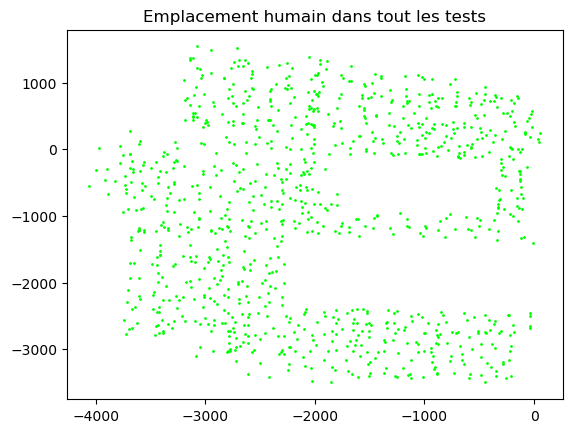

In [147]:
#Montrons avec un graph la répartition des coordonnées de l'humain
#On peut voir des carrés blancs, cela représente par exemple un canapé ou une table
#Où l'humain durant les tests ne pouvait pas se placer
plt.plot([tab_file[0] for tab_file in file], [tab_file2[1] for tab_file2 in file], linestyle = 'none', marker = 'o', c = 'lime',
  markersize = 1)
plt.title('Emplacement humain dans tout les tests')
plt.show()

In [150]:
#On récupère les données RIR : Room Impulse Response
rir = np.load('data/LivingRoom_preprocessed_hack/Human1/deconvoled_trim.npy')
rir

array([[[ 9.07240337e-06,  1.71257434e-05,  1.22597794e-05, ...,
          8.86178623e-06,  1.40686043e-05,  1.06616626e-05],
        [-8.23853679e-06, -8.23373648e-06, -8.74563466e-06, ...,
          2.87394778e-06, -8.90485808e-06, -3.52464713e-06],
        [ 6.62780906e-07, -1.40201587e-06,  1.83228190e-06, ...,
         -1.06218545e-06,  8.53497477e-06,  2.28155182e-06],
        [ 8.11119719e-07, -2.47451499e-06,  5.82140547e-06, ...,
          7.73804004e-06,  2.29692650e-05,  1.10566034e-05]],

       [[ 1.64466037e-05,  1.53698293e-05,  1.91599720e-05, ...,
          1.76548729e-05,  1.70955263e-05,  1.41169767e-05],
        [ 1.05826217e-07,  9.13145777e-06,  1.76140716e-07, ...,
          1.21369967e-05,  1.55958387e-05,  1.23088676e-05],
        [ 7.06836090e-06,  3.26818258e-06,  7.15508941e-06, ...,
          4.64980394e-06,  8.96262554e-06,  6.55734584e-06],
        [-3.18089551e-05, -8.93297238e-06, -2.51026504e-05, ...,
         -7.02741545e-07,  1.34268867e-05,  3.24307

In [152]:
#Regardons plus en détail la data rir
len(rir[0])
print(" ")
len(rir[0][0])

print(rir[0])
print(len(rir[0][0]))

 
[[ 9.0724034e-06  1.7125743e-05  1.2259779e-05 ...  8.8617862e-06
   1.4068604e-05  1.0661663e-05]
 [-8.2385368e-06 -8.2337365e-06 -8.7456347e-06 ...  2.8739478e-06
  -8.9048581e-06 -3.5246471e-06]
 [ 6.6278091e-07 -1.4020159e-06  1.8322819e-06 ... -1.0621854e-06
   8.5349748e-06  2.2815518e-06]
 [ 8.1111972e-07 -2.4745150e-06  5.8214055e-06 ...  7.7380400e-06
   2.2969265e-05  1.1056603e-05]]
667200


In [153]:
#On applique la méthode RMS, pour Root Mean Square
#Qui permet de donner la moyenne de l'amplitude des sons de rir en 1 seule donnée
RMS_levels = np.sqrt(np.mean(rir**2, axis=2))  # compute RMS along the samples axis
print(RMS_levels)

[[0.00052505 0.00050232 0.00070836 0.00042991]
 [0.00052084 0.00049965 0.00070709 0.0004291 ]
 [0.00052198 0.00049891 0.00070534 0.00042922]
 ...
 [0.0005181  0.00049532 0.00068871 0.00042133]
 [0.00051583 0.00049072 0.0006886  0.00041962]
 [0.00051578 0.00049757 0.00041044 0.00035783]]


In [154]:
#On normalise les RMS pour le KNN
#On utilise le StandardScaler
scaler = StandardScaler()
normalized_RMS = scaler.fit_transform(RMS_levels)
print(normalized_RMS)

[[  0.807686     0.89319843   0.3703625    0.55446833]
 [  0.6148092    0.5601817    0.32530993   0.49623522]
 [  0.6670591    0.46835804   0.26275572   0.5050229 ]
 ...
 [  0.48971906   0.02091012  -0.3304132   -0.05839473]
 [  0.38563752  -0.5528933   -0.33424938  -0.18044513]
 [  0.38350895   0.30132347 -10.254325    -4.594716  ]]


In [155]:
#On divise les données en données d'entrainement pour notre Knn
#Et en donnée de test pour tester notre entrainement de Knn pour voir si il arrive bien à prédire
#On prend 80% d'entrainement et 20% de test
X_train, X_test, y_train, y_test = train_test_split(normalized_RMS, file, test_size=0.2, random_state=42)

In [167]:
#On initialise notre Knn en prenant en compte 5 voisins
k = 1
knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=1, weights='distance')

In [168]:
#On redimentionne les données de test
query_RMS = X_test.reshape(1, -1)

In [169]:
#Avec notre Knn, on essaye de prédire la position de l'humain sur toutes les données de test
#predicted_position = knn.predict(query_RMS)
predicted_position = knn.predict(X_test)
print("Predicted human position:", predicted_position)

Predicted human position: [[-2.59240664e+03 -1.81268116e+03]
 [-1.97755137e+03 -1.09837625e+03]
 [-1.51980368e+03 -3.22137729e+03]
 [-6.12497813e+02  5.93659585e+01]
 [-1.70745146e+03 -2.45359833e+03]
 [-2.61453319e+03  1.29496135e+03]
 [-2.02041839e+03 -2.86903782e+03]
 [-9.11571118e+02  2.99987968e+02]
 [-2.86297729e+02 -3.19645316e+03]
 [-3.36668105e+02  6.39432312e+02]
 [-8.34744284e+01  2.31544672e+02]
 [-2.84340142e+03 -1.58731558e+03]
 [-1.15582389e+03 -2.90680147e+03]
 [-1.64698362e+03 -2.54501995e+03]
 [-9.23771106e+02 -3.09521779e+03]
 [-3.72544453e+03 -6.02780519e+02]
 [-3.32576150e+03 -6.58319732e+02]
 [-2.74545760e+03 -2.68785930e+03]
 [-2.19160896e+03 -1.08206809e+03]
 [-3.60896403e+03 -1.92655279e+03]
 [-2.07168472e+03 -6.10934312e+02]
 [-1.97608820e+02 -3.52065408e+00]
 [-2.65594878e+03 -3.03608598e+02]
 [-3.41007452e+03 -1.57985906e+03]
 [-1.98842264e+03  8.35553562e+02]
 [-2.86726156e+03 -1.95913304e+03]
 [-1.99983744e+03  1.12069734e+03]
 [-1.51980368e+03 -3.22137729

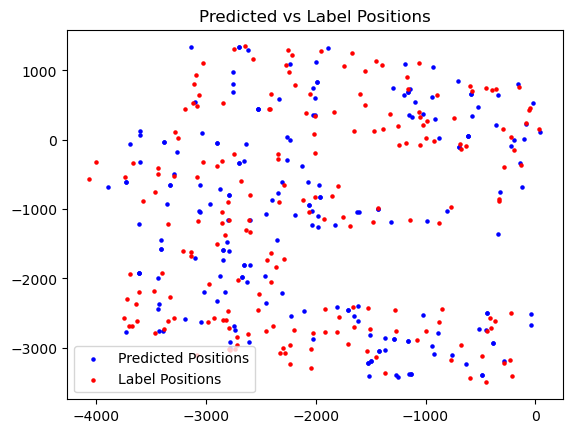

In [170]:
#On montre un graph représentant la chambre, avec :
# - En point bleu, les positions humaines que notre Knn à prédit
# - En point rouge, les vraies positions des humains dans chaque test
plt.scatter(predicted_position[:, 0], predicted_position[:, 1], color='blue', label='Predicted Positions', s=5)
plt.scatter(y_test[:, 0], y_test[:, 1], color='red', label='Label Positions', s=5)
plt.title('Predicted vs Label Positions')
plt.legend()
plt.show()

In [171]:
good_result = 0
intervalle = 500
for i in range(0, len(predicted_position)):
    if predicted_position[i][0] > y_test[i][0] - intervalle and predicted_position[i][0] < y_test[i][0] + intervalle:
        if predicted_position[i][1] > y_test[i][1] - intervalle and predicted_position[i][1] < y_test[i][1] + intervalle:
            good_result += 1

print("Le pourcentage de bonnes prédictions est de : " + str(good_result / len(predicted_position)))

Le pourcentage de bonnes prédictions est de : 0.425


In [172]:
eucl = np.sqrt(np.mean((predicted_position - y_test)**2))
print(eucl)

1084.4585200813606
